# Week 4: Improved Trading System

## Objective
Test all Week 4 improvements and compare with Week 3 baseline.

## Key Improvements
1.  Market regime detection
2.  Meta-strategy rules (cooldown after losses)
3.  Better LLM prompts (rich context)
4.  Performance feedback loop
5.  Regime-adjusted position sizing

---

## Part 1: Setup & Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data
import ccxt

# Week 3 modules (from outputs folder)
import sys
sys.path.append('/mnt/user-data/outputs')

# Week 4 improvements (current directory)
from market_regime import MarketRegimeDetector
from improved_llm_strategy import ImprovedLLMStrategy
from week4_backtest_engine import Week4BacktestEngine

# Plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)


## Part 2: Test Market Regime Detection

Let's first test the regime detector on Week 3 data.

In [2]:
# Fetch same data as Week 3
print("Fetching BTC/USDT data...")
exchange = ccxt.binance({'enableRateLimit': True})

# Get data from same period as Week 3
since = exchange.milliseconds() - (90 * 24 * 60 * 60 * 1000)  # 90 days ago
ohlcv = exchange.fetch_ohlcv('BTC/USDT', '1h', since, limit=1000)

# Create DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Calculate indicators
def calculate_indicators(df):
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Moving Averages
    df['MA_20'] = df['close'].rolling(20).mean()
    df['MA_50'] = df['close'].rolling(50).mean()
    df['MA_200'] = df['close'].rolling(200).mean()
    
    # ATR
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(14).mean()
    
    return df.dropna()

df = calculate_indicators(df)

print(f" Fetched {len(df)} data points")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Price range: ${df['close'].min():,.2f} - ${df['close'].max():,.2f}")

Fetching BTC/USDT data...
 Fetched 801 data points
Date range: 2025-10-11 17:00:00 to 2025-11-14 01:00:00
Price range: $98,162.11 - $116,053.49


In [3]:
# Test regime detection at different points
detector = MarketRegimeDetector()

# Test at multiple points
test_points = [300, 500, 700, 900, -1]

for point in test_points:
    test_data = df.iloc[:point] if point > 0 else df
    regime = detector.detect_regime(test_data)
    
    print(f"\n Point {point} ({test_data.index[-1].date()}):")
    print(f"   Regime: {regime['regime']}")
    print(f"   Confidence: {regime['confidence']}%")
    print(f"   Recommendation: {regime['recommendation']}")
    print(f"   Reason: {regime['reason']}")
    
    # Test if trades would be allowed
    long_check = detector.should_allow_trade(regime, 'LONG')
    print(f"   LONG allowed: {long_check['allowed']} - {long_check['reason']}")


 Point 300 (2025-10-24):
   Regime: RANGE
   Confidence: 80%
   Recommendation: MEAN_REVERSION
   Reason: Market ranging 4.5% with clear support/resistance
   LONG allowed: True - ALLOWED: RANGE supports LONG

 Point 500 (2025-11-01):
   Regime: RANGE
   Confidence: 80%
   Recommendation: MEAN_REVERSION
   Reason: Market ranging 4.6% with clear support/resistance
   LONG allowed: True - ALLOWED: RANGE supports LONG

 Point 700 (2025-11-09):
   Regime: RANGE
   Confidence: 80%
   Recommendation: MEAN_REVERSION
   Reason: Market ranging 3.6% with clear support/resistance
   LONG allowed: True - ALLOWED: RANGE supports LONG

 Point 900 (2025-11-14):
   Regime: VOLATILE
   Confidence: 90%
   Recommendation: REDUCE_SIZE
   Reason: Extreme volatility (ATR 100th percentile)
   LONG allowed: True - ALLOWED but high volatility - reduce size

 Point -1 (2025-11-14):
   Regime: VOLATILE
   Confidence: 90%
   Recommendation: REDUCE_SIZE
   Reason: Extreme volatility (ATR 100th percentile)
   LONG

## Part 3: Visualize Regime Detection

Let's see how regime changed over time.

 Detected 61 regime points


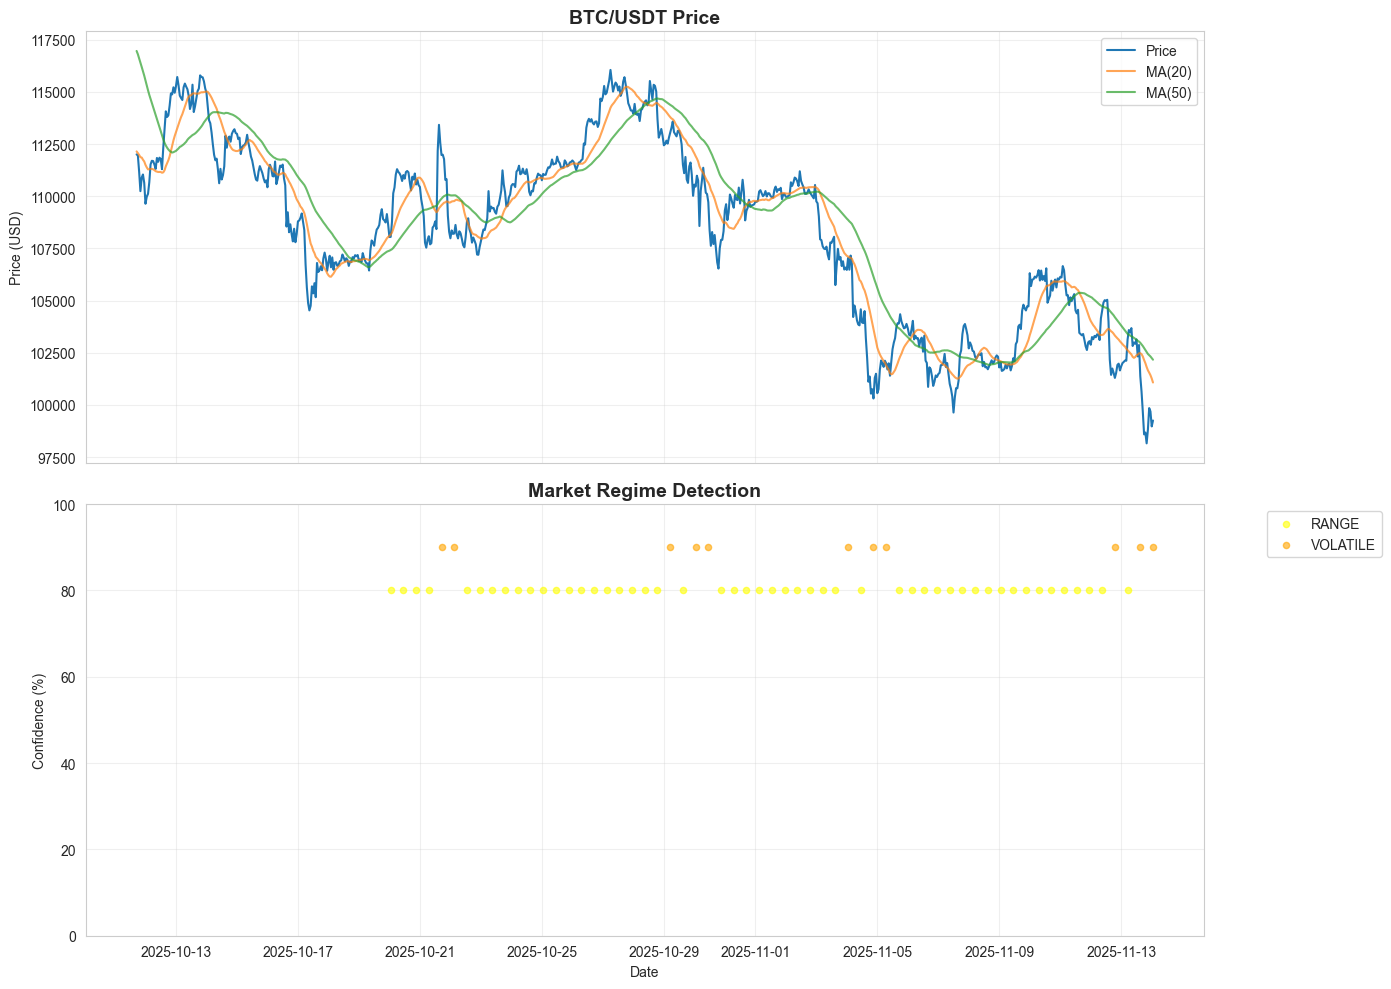


 Regime Distribution:
regime
RANGE       50
VOLATILE    11
Name: count, dtype: int64


In [4]:
# Detect regime for entire dataset

regime_history = []
for i in range(200, len(df), 10):  # Every 10 bars to speed up
    test_data = df.iloc[:i]
    regime = detector.detect_regime(test_data)
    regime_history.append({
        'timestamp': df.index[i],
        'regime': regime['regime'],
        'confidence': regime['confidence']
    })

regime_df = pd.DataFrame(regime_history)
regime_df.set_index('timestamp', inplace=True)

print(f" Detected {len(regime_df)} regime points")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price chart
axes[0].plot(df.index, df['close'], linewidth=1.5, label='Price')
axes[0].plot(df.index, df['MA_20'], alpha=0.7, label='MA(20)')
axes[0].plot(df.index, df['MA_50'], alpha=0.7, label='MA(50)')
axes[0].set_title('BTC/USDT Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regime colors
regime_colors = {
    'STRONG_TREND_UP': 'green',
    'STRONG_TREND_DOWN': 'red',
    'TREND_UP': 'lightgreen',
    'TREND_DOWN': 'lightcoral',
    'RANGE': 'yellow',
    'VOLATILE': 'orange',
    'TRANSITIONAL': 'gray'
}

# Plot regime blocks
for regime_type, color in regime_colors.items():
    mask = regime_df['regime'] == regime_type
    if mask.any():
        axes[1].scatter(regime_df.index[mask], 
                       regime_df['confidence'][mask],
                       c=color, label=regime_type, alpha=0.6, s=20)

axes[1].set_title('Market Regime Detection', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Confidence (%)')
axes[1].set_xlabel('Date')
axes[1].set_ylim(0, 100)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print regime distribution
print("\n Regime Distribution:")
print(regime_df['regime'].value_counts())

## Part 4: Run Week 4 Backtest

Now let's run the improved system!

In [6]:
# Load API key from .env file
import os
from dotenv import load_dotenv

load_dotenv()
DEEPSEEK_API_KEY = os.getenv('DEEPSEEK_API_KEY')

if DEEPSEEK_API_KEY:
    print(f" DeepSeek API key loaded: {DEEPSEEK_API_KEY[:10]}...")
    print("   Using LIVE LLM API calls!")
    mode = "LIVE_LLM"
else:
    print(" DeepSeek API key not found in .env file")
    print("   Using rule-based fallback")
    mode = "RULE_BASED"
    DEEPSEEK_API_KEY = None

# Initialize Week 4 engine with API key
engine = Week4BacktestEngine(
    initial_capital=10000,
    fee_rate=0.001,
    slippage_pct=0.001,
    risk_per_trade=0.02,
    stop_loss_pct=0.02,
    api_key=DEEPSEEK_API_KEY,  # Will use live LLM if key present
    trading_mode='CONSERVATIVE'
)

print(f"\n Week 4 Engine initialized in {mode} mode")
print("\nRunning backtest...")
if mode == "LIVE_LLM":
    print(" This will make API calls")
    print("   Estimated cost: ~$0.02 for ~1000 signals")
print()

2026-01-01 17:49:46,520 - portfolio - INFO - Portfolio initialized with $10,000.00
2026-01-01 17:49:46,521 - risk_manager - INFO - RiskManager initialized: max_pos=95.0%, risk_per_trade=2.0%, stop_loss=2.0%


 DeepSeek API key loaded: sk-2822f3e...
   Using LIVE LLM API calls!


2026-01-01 17:49:47,565 - llm_signal - INFO - Using DeepSeek API endpoint: https://api.deepseek.com
2026-01-01 17:49:47,567 - llm_signal - INFO - Initialized LLMSignalGenerator with deepseek/deepseek-chat


✅ Trading Mode: CONSERVATIVE
   Max Consecutive Losses: 2
   Min Confidence: 70
   Extreme Volatility Threshold: 95%
✅ Using adjustable strategy in CONSERVATIVE mode

 Week 4 Engine initialized in LIVE_LLM mode

Running backtest...
 This will make API calls
   Estimated cost: ~$0.02 for ~1000 signals



In [8]:
# Run backtest with progress tracking
import time

start_time = time.time()

results_conservative = engine.run(df, symbol='BTC/USDT')

end_time = time.time()
elapsed = end_time - start_time

print(f"\n Backtest completed in {elapsed/60:.1f} minutes")

if mode == "LIVE_LLM":
    total_signals = len(results_conservative['signal_history'])
    cost = total_signals * 0.00002  # DeepSeek pricing
    print(f" Total API calls: {total_signals}")
    print(f" Estimated cost: ${cost:.4f}")

# Print results
engine.print_results(results_conservative)


WEEK 4 BACKTEST - IMPROVED_LLM
Initial Capital: $10,000.00
Data Points: 801
Date Range: 2025-10-11 17:00:00 to 2025-11-14 01:00:00

Progress: 100/801 (12.5%) | Trades: 6 | Regime: RANGE
Progress: 200/801 (25.0%) | Trades: 6 | Regime: RANGE
Progress: 300/801 (37.5%) | Trades: 6 | Regime: RANGE
Progress: 400/801 (49.9%) | Trades: 6 | Regime: RANGE
Progress: 500/801 (62.4%) | Trades: 6 | Regime: RANGE
Progress: 600/801 (74.9%) | Trades: 6 | Regime: RANGE
Progress: 700/801 (87.4%) | Trades: 6 | Regime: RANGE
Progress: 800/801 (99.9%) | Trades: 6 | Regime: VOLATILE

SIGNAL SUMMARY
Total Signals: 701
  LONG:  0 (0.0%)
  SHORT: 0 (0.0%)
  HOLD:  701 (100.0%)

Meta-Strategy Blocks: 701 (100.0%)


 Backtest completed in 0.0 minutes
 Total API calls: 1402
 Estimated cost: $0.0280

PERFORMANCE METRICS REPORT

💰 CAPITAL METRICS:
Initial Capital:  $10,000.00
Final Capital:    $9,907.72
Total Return:     -0.92%
Total PnL:        $-92.28

📈 TRADE METRICS:
Total Trades:     3
Winning Trades:   1
Losi

## Part 4.5: LLM Reasoning Examples

Let's see what the LLM was thinking! (Only if using live API)

In [10]:
if mode == "LIVE_LLM":
    signal_history = results_conservative['signal_history']
    
    print("\n" + "="*70)
    print("LLM REASONING EXAMPLES")
    print("="*70)
    
    # Show first 5 signals
    print("\n First 5 Signals:")
    for i, row in signal_history.head(5).iterrows():
        print(f"\n{i+1}. {row['timestamp']}")
        print(f"   Signal: {row['signal']}")
        print(f"   Confidence: {row['confidence']:.0f}%")
        print(f"   Reasoning: {row['reasoning'][:100]}..." if len(str(row['reasoning'])) > 100 else f"   Reasoning: {row['reasoning']}")
    
    # Show signals that led to trades
    long_signals = signal_history[signal_history['signal'] == 'LONG']
    if len(long_signals) > 0:
        print(f"\n\n LONG Signals ({len(long_signals)} total):")
        for i, row in long_signals.head(3).iterrows():
            print(f"\n{row['timestamp']}")
            print(f"   Confidence: {row['confidence']:.0f}%")
            print(f"   Reasoning: {row['reasoning']}")
    
    # Show blocked signals
    blocked = signal_history[signal_history['reasoning'].str.contains('BLOCK|COOLDOWN|WAIT', na=False)]
    if len(blocked) > 0:
        print(f"\n\n BLOCKED Signals ({len(blocked)} total):")
        print("These are signals that meta-strategy prevented:")
        for i, row in blocked.head(3).iterrows():
            print(f"\n{row['timestamp']}")
            print(f"   Original Signal: {row['signal']}")
            print(f"   Block Reason: {row['reasoning']}")
    
    print("\n" + "="*70)
else:
    print("\n Using rule-based mode - no LLM reasoning to display")
    print("   (Set up .env with DEEPSEEK_API_KEY to see LLM reasoning)")


LLM REASONING EXAMPLES

 First 5 Signals:

1. 2025-10-15 21:00:00
   Signal: HOLD
   Confidence: 0%
   Reasoning: Confidence 0% below threshold 70%

2. 2025-10-15 22:00:00
   Signal: HOLD
   Confidence: 0%
   Reasoning: Confidence 0% below threshold 70%

3. 2025-10-15 23:00:00
   Signal: HOLD
   Confidence: 0%
   Reasoning: Confidence 0% below threshold 70%

4. 2025-10-16 00:00:00
   Signal: HOLD
   Confidence: 0%
   Reasoning: Confidence 0% below threshold 70%

5. 2025-10-16 01:00:00
   Signal: HOLD
   Confidence: 0%
   Reasoning: Confidence 0% below threshold 70%


 LONG Signals (11 total):

2025-10-21 03:00:00
   Confidence: 76%
   Reasoning: Oversold (RSI=26.9) in uptrend

2025-10-21 04:00:00
   Confidence: 89%
   Reasoning: Oversold (RSI=20.3) in uptrend

2025-10-21 05:00:00
   Confidence: 90%
   Reasoning: Oversold (RSI=19.7) in uptrend


 BLOCKED Signals (1002 total):
These are signals that meta-strategy prevented:

2025-10-16 16:00:00
   Original Signal: HOLD
   Block Reason: 

## Part 5: Analyze Week 4 vs Week 3

Let's compare improvements!

In [12]:
# Week 3 Results (from your previous backtest)
week3_results = {
    'RSI': {'return': 1.09, 'trades': 12, 'win_rate': 50.0, 'max_dd': 7.45},
    'LLM': {'return': -4.75, 'trades': 16, 'win_rate': 31.25, 'max_dd': 13.05},
    'B&H': {'return': -7.62, 'trades': 1, 'win_rate': 0.0, 'max_dd': 20.01}
}

# Week 4 Results
week4_metrics = results_conservative['metrics']
week4_results = {
    'Week4_Improved': {
        'return': week4_metrics.get('total_return_pct', 0),
        'trades': week4_metrics.get('total_trades', 0),
        'win_rate': week4_metrics.get('win_rate', 0),
        'max_dd': week4_metrics.get('max_drawdown_pct', 0)
    }
}

# Combine
all_results = {**week3_results, **week4_results}

# Create comparison table
comparison_df = pd.DataFrame(all_results).T

print("\n" + "="*70)
print("WEEK 3 vs WEEK 4 COMPARISON")
print("="*70)
print(comparison_df)
print("="*70)


WEEK 3 vs WEEK 4 COMPARISON
                  return  trades   win_rate     max_dd
RSI             1.090000    12.0  50.000000   7.450000
LLM            -4.750000    16.0  31.250000  13.050000
B&H            -7.620000     1.0   0.000000  20.010000
Week4_Improved -0.922808     3.0  33.333333   4.184583


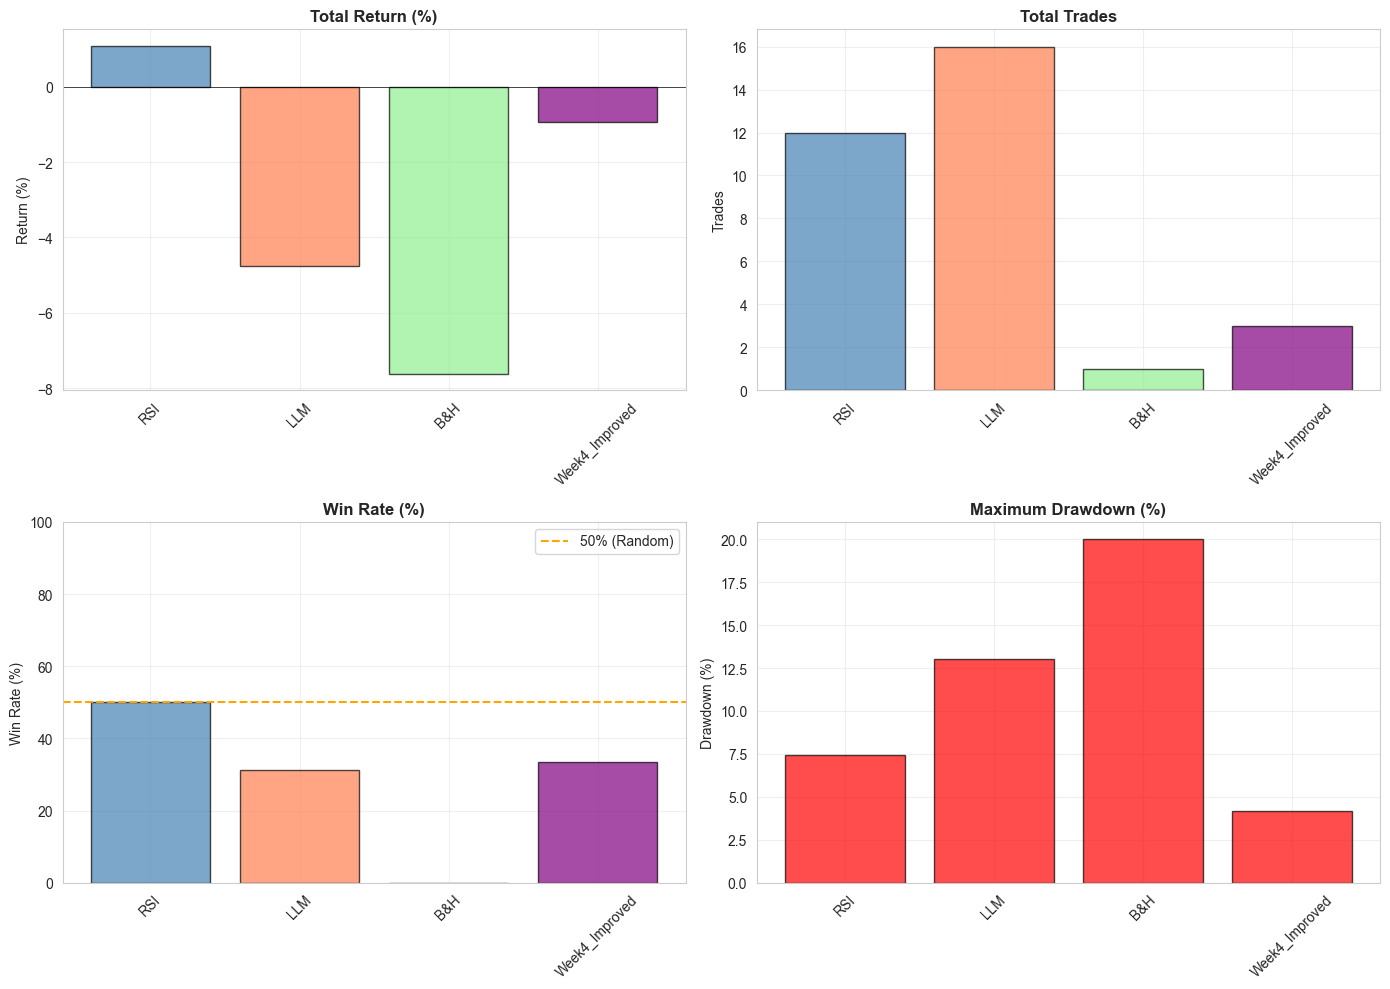

 Comparison chart saved: week4_comparison.png


In [13]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

strategies = comparison_df.index.tolist()
colors = ['steelblue', 'coral', 'lightgreen', 'purple']

# Total Return
axes[0, 0].bar(strategies, comparison_df['return'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 0].set_title('Total Return (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Number of Trades
axes[0, 1].bar(strategies, comparison_df['trades'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Total Trades', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Trades')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Win Rate
axes[1, 0].bar(strategies, comparison_df['win_rate'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].axhline(y=50, color='orange', linestyle='--', label='50% (Random)')
axes[1, 0].set_title('Win Rate (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Win Rate (%)')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Max Drawdown
axes[1, 1].bar(strategies, comparison_df['max_dd'], color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Maximum Drawdown (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Drawdown (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('week4_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Comparison chart saved: week4_comparison.png")

## Part 6: Analyze Improvements

What did Week 4 changes accomplish?

In [15]:
# Regime analysis
regime_history = results_conservative['regime_history']
signal_history = results_conservative['signal_history']

print("\n" + "="*70)
print("WEEK 4 IMPROVEMENTS ANALYSIS")
print("="*70)

print("\n REGIME DETECTION:")
print(f"   Total regime detections: {len(regime_history)}")
print(f"   \nRegime distribution:")
print(regime_history['regime'].value_counts())

print("\n SIGNAL GENERATION:")
print(f"   Total signals: {len(signal_history)}")
print(f"   \nSignal distribution:")
print(signal_history['signal'].value_counts())

# Count meta-overrides
meta_overrides = sum('BLOCK' in str(r) or 'COOLDOWN' in str(r) or 'WAIT' in str(r) 
                    for r in signal_history['reasoning'])
print(f"\n META-STRATEGY INTERVENTIONS:")
print(f"   Total blocks/cooldowns: {meta_overrides}")
print(f"   Percentage blocked: {meta_overrides/len(signal_history)*100:.1f}%")

print("\n COMPARISON TO WEEK 3 LLM:")
week3_llm = week3_results['LLM']
week4_improved = week4_results['Week4_Improved']

return_diff = week4_improved['return'] - week3_llm['return']
trades_diff = week4_improved['trades'] - week3_llm['trades']
wr_diff = week4_improved['win_rate'] - week3_llm['win_rate']
dd_diff = week4_improved['max_dd'] - week3_llm['max_dd']

print(f"   Return improvement:    {return_diff:+.2f}%")
print(f"   Trades difference:     {trades_diff:+d}")
print(f"   Win rate improvement:  {wr_diff:+.2f}%")
print(f"   Drawdown change:       {dd_diff:+.2f}%")

print("\n" + "="*70)


WEEK 4 IMPROVEMENTS ANALYSIS

 REGIME DETECTION:
   Total regime detections: 1402
   
Regime distribution:
regime
RANGE       1184
VOLATILE     218
Name: count, dtype: int64

 SIGNAL GENERATION:
   Total signals: 1402
   
Signal distribution:
signal
HOLD     1363
SHORT      28
LONG       11
Name: count, dtype: int64

 META-STRATEGY INTERVENTIONS:
   Total blocks/cooldowns: 1002
   Percentage blocked: 71.5%

 COMPARISON TO WEEK 3 LLM:
   Return improvement:    +3.83%
   Trades difference:     -13
   Win rate improvement:  +2.08%
   Drawdown change:       -8.87%



2026-01-01 17:53:53,191 - portfolio - INFO - Portfolio initialized with $10,000.00
2026-01-01 17:53:53,192 - risk_manager - INFO - RiskManager initialized: max_pos=95.0%, risk_per_trade=2.0%, stop_loss=2.0%


WEEK 4: TRADING MODE COMPARISON

 This will take ~20-30 minutes with API calls
 Estimated cost: ~$0.04

Running 3 modes: CONSERVATIVE (done), BALANCED, AGGRESSIVE


Testing Week 4 - BALANCED Mode


2026-01-01 17:53:53,449 - llm_signal - INFO - Using DeepSeek API endpoint: https://api.deepseek.com
2026-01-01 17:53:53,450 - llm_signal - INFO - Initialized LLMSignalGenerator with deepseek/deepseek-chat


✅ Trading Mode: BALANCED
   Max Consecutive Losses: 2
   Min Confidence: 60
   Extreme Volatility Threshold: 97%
✅ Using adjustable strategy in BALANCED mode

WEEK 4 BACKTEST - IMPROVED_LLM
Initial Capital: $10,000.00
Data Points: 801
Date Range: 2025-10-11 17:00:00 to 2025-11-14 01:00:00

⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
Progress: 100/801 (12.5%) | Trades: 0 | Regime: RANGE
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' objec

2026-01-01 17:53:53,680 - portfolio - INFO - BUY 0.069864 BTC/USDT @ $109,168.28 | Fee: $7.63
2026-01-01 17:53:53,683 - portfolio - WARNING - Insufficient funds to buy 0.07849839653596355 BTC/USDT at $107887.47969999998
2026-01-01 17:53:53,686 - portfolio - WARNING - Insufficient funds to buy 0.07854072498947433 BTC/USDT at $107644.65711999999
2026-01-01 17:53:53,689 - portfolio - WARNING - Insufficient funds to buy 0.07086254441590639 BTC/USDT at $108017.69978999998
2026-01-01 17:53:53,692 - portfolio - WARNING - Insufficient funds to buy 0.06355738002097443 BTC/USDT at $108194.45636999999
2026-01-01 17:53:53,695 - portfolio - WARNING - Insufficient funds to buy 0.07851301665154072 BTC/USDT at $107803.48578999998
2026-01-01 17:53:53,699 - portfolio - WARNING - Insufficient funds to buy 0.07850282494453083 BTC/USDT at $107862.02427
2026-01-01 17:53:53,702 - portfolio - WARNING - Insufficient funds to buy 0.06879539730022428 BTC/USDT at $108608.05955999998
2026-01-01 17:53:53,710 - port

⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' ob

2026-01-01 17:53:54,011 - portfolio - INFO - BUY 0.063751 BTC/USDT @ $114,075.63 | Fee: $7.27
2026-01-01 17:53:54,031 - portfolio - WARNING - Insufficient funds to buy 0.06390678055150813 BTC/USDT at $114302.55836999998


⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' ob

2026-01-01 17:53:54,098 - portfolio - INFO - SELL 0.063751 BTC/USDT @ $111,398.23 | PnL: $-185.06


⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' ob

2026-01-01 17:53:54,378 - portfolio - INFO - BUY 0.070971 BTC/USDT @ $109,775.17 | Fee: $7.79
2026-01-01 17:53:54,381 - portfolio - WARNING - Insufficient funds to buy 0.07326373862171696 BTC/USDT at $109142.86382999999
2026-01-01 17:53:54,400 - portfolio - INFO - SELL 0.070971 BTC/USDT @ $107,360.76 | PnL: $-186.76


⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' ob

2026-01-01 17:53:54,890 - portfolio - INFO - Portfolio initialized with $10,000.00
2026-01-01 17:53:54,891 - risk_manager - INFO - RiskManager initialized: max_pos=95.0%, risk_per_trade=2.0%, stop_loss=2.0%


Progress: 800/801 (99.9%) | Trades: 6 | Regime: VOLATILE

SIGNAL SUMMARY
Total Signals: 701
  LONG:  12 (1.7%)
  SHORT: 73 (10.4%)
  HOLD:  616 (87.9%)

Meta-Strategy Blocks: 616 (87.9%)


 BALANCED Mode Results:
   Total Trades: 3
   Win Rate: 33.33%
   Return: -0.98%
   Max Drawdown: 4.41%

Testing Week 4 - AGGRESSIVE Mode


2026-01-01 17:53:55,142 - llm_signal - INFO - Using DeepSeek API endpoint: https://api.deepseek.com
2026-01-01 17:53:55,143 - llm_signal - INFO - Initialized LLMSignalGenerator with deepseek/deepseek-chat


✅ Trading Mode: AGGRESSIVE
   Max Consecutive Losses: 3
   Min Confidence: 50
   Extreme Volatility Threshold: 98%
✅ Using adjustable strategy in AGGRESSIVE mode

WEEK 4 BACKTEST - IMPROVED_LLM
Initial Capital: $10,000.00
Data Points: 801
Date Range: 2025-10-11 17:00:00 to 2025-11-14 01:00:00

⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
Progress: 100/801 (12.5%) | Trades: 0 | Regime: RANGE
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' o

2026-01-01 17:53:55,439 - portfolio - INFO - BUY 0.060829 BTC/USDT @ $109,624.43 | Fee: $6.67
2026-01-01 17:53:55,443 - portfolio - WARNING - Insufficient funds to buy 0.07478253843830265 BTC/USDT at $109168.27921999998
2026-01-01 17:53:55,448 - portfolio - WARNING - Insufficient funds to buy 0.07838541149333043 BTC/USDT at $107887.47969999998
2026-01-01 17:53:55,451 - portfolio - WARNING - Insufficient funds to buy 0.07844491132828775 BTC/USDT at $107644.65711999999
2026-01-01 17:53:55,455 - portfolio - WARNING - Insufficient funds to buy 0.07597580816662683 BTC/USDT at $108017.69978999998
2026-01-01 17:53:55,459 - portfolio - WARNING - Insufficient funds to buy 0.06866904404101681 BTC/USDT at $108194.45636999999
2026-01-01 17:53:55,464 - portfolio - WARNING - Insufficient funds to buy 0.07840596255040314 BTC/USDT at $107803.48578999998
2026-01-01 17:53:55,468 - portfolio - WARNING - Insufficient funds to buy 0.07839163637416172 BTC/USDT at $107862.02427
2026-01-01 17:53:55,471 - port

⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
Progress: 200/801 (25.0%) | Trades: 0 | Regime: RANGE
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_s

2026-01-01 17:53:55,865 - portfolio - INFO - BUY 0.060679 BTC/USDT @ $114,569.63 | Fee: $6.95
2026-01-01 17:53:55,875 - portfolio - WARNING - Insufficient funds to buy 0.05774535048798866 BTC/USDT at $114221.75764999999


⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
Progress: 300/801 (37.5%) | Trades: 2 | Regime: RANGE
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_s

2026-01-01 17:53:55,881 - portfolio - WARNING - Insufficient funds to buy 0.06564174336766197 BTC/USDT at $114075.63166999999
2026-01-01 17:53:55,891 - portfolio - WARNING - Insufficient funds to buy 0.059811990603624104 BTC/USDT at $114022.14824
2026-01-01 17:53:55,899 - portfolio - WARNING - Insufficient funds to buy 0.06142475878829493 BTC/USDT at $113718.91530999998
2026-01-01 17:53:55,903 - portfolio - WARNING - Insufficient funds to buy 0.061849318210195695 BTC/USDT at $114229.63552
2026-01-01 17:53:55,907 - portfolio - WARNING - Insufficient funds to buy 0.06587386977309571 BTC/USDT at $114302.55836999998
2026-01-01 17:53:55,972 - portfolio - INFO - SELL 0.060679 BTC/USDT @ $111,398.23 | PnL: $-206.15


⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
Progress: 400/801 (49.9%) | Trades: 3 | Regime: RANGE
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_s

2026-01-01 17:53:56,201 - portfolio - INFO - BUY 0.060654 BTC/USDT @ $110,100.89 | Fee: $6.68
2026-01-01 17:53:56,204 - portfolio - WARNING - Insufficient funds to buy 0.061493636947944595 BTC/USDT at $110009.88999
2026-01-01 17:53:56,211 - portfolio - WARNING - Insufficient funds to buy 0.07247839529569611 BTC/USDT at $109775.16549999999
2026-01-01 17:53:56,214 - portfolio - WARNING - Insufficient funds to buy 0.07480701177926494 BTC/USDT at $109142.86382999999
2026-01-01 17:53:56,222 - portfolio - INFO - SELL 0.060654 BTC/USDT @ $107,499.14 | PnL: $-171.00


⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' object has no attribute 'generate_signal_raw'
⚠️ LLM call failed: 'LLMSignalGenerator' ob

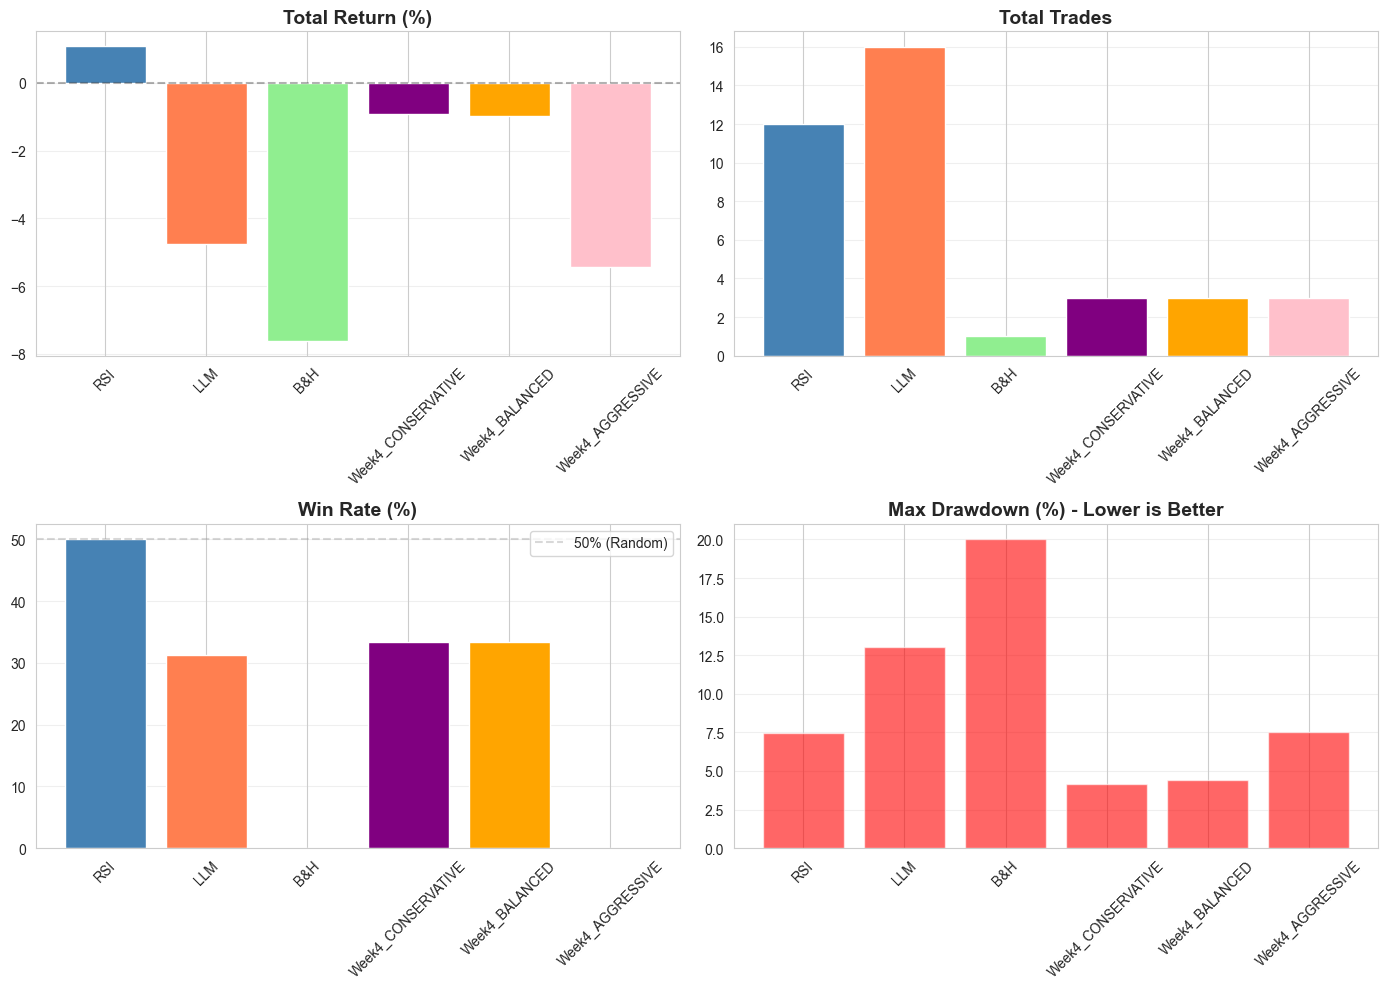


KEY INSIGHTS

 Best Return: RSI (+1.09%)
 Most Trades: LLM (16 trades)
 Best Win Rate: RSI (50.00%)
 Lowest Drawdown: Week4_CONSERVATIVE (4.18%)

📈 Week 4 Trading Activity:
   CONSERVATIVE   :  3 trades
   BALANCED       :  3 trades
   AGGRESSIVE     :  3 trades

 Week 3 LLM had: 16 trades

 Week 4 Improvements (vs Week 3 LLM):

CONSERVATIVE Mode:
   Return Change: +3.83%
   Trade Difference: -13
   Win Rate Change: +2.08%
   Drawdown Change: -8.87%

BALANCED Mode:
   Return Change: +3.77%
   Trade Difference: -13
   Win Rate Change: +2.08%
   Drawdown Change: -8.64%

AGGRESSIVE Mode:
   Return Change: -0.69%
   Trade Difference: -13
   Win Rate Change: -31.25%
   Drawdown Change: -5.54%

 Full comparison saved: week4_all_modes_comparison.csv


In [16]:
# ============================================================================
# WEEK 4: COMPARE ALL TRADING MODES
# This cell runs BALANCED and AGGRESSIVE modes and compares with existing results
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
from week4_backtest_engine import Week4BacktestEngine
import os

print("="*70)
print("WEEK 4: TRADING MODE COMPARISON")
print("="*70)
print("\n This will take ~20-30 minutes with API calls")
print(" Estimated cost: ~$0.04")
print("\nRunning 3 modes: CONSERVATIVE (done), BALANCED, AGGRESSIVE\n")

# Your Week 3 results (from previous backtest - UPDATE THESE WITH YOUR ACTUAL VALUES!)
week3_results = {
    'RSI': {'return': 1.09, 'trades': 12, 'win_rate': 50.0, 'max_dd': 7.45},
    'LLM': {'return': -4.75, 'trades': 16, 'win_rate': 31.25, 'max_dd': 13.05},
    'B&H': {'return': -7.62, 'trades': 1, 'win_rate': 0.0, 'max_dd': 20.01}
}

# Initialize results dict with CONSERVATIVE (already run)
week4_results = {
    'Week4_CONSERVATIVE': {
        'return': results_conservative['metrics']['total_return_pct'],
        'trades': results_conservative['metrics']['total_trades'],
        'win_rate': results_conservative['metrics']['win_rate'],
        'max_dd': results_conservative['metrics']['max_drawdown_pct']
    }
}

# Run BALANCED and AGGRESSIVE modes
new_modes = ['BALANCED', 'AGGRESSIVE']

for mode in new_modes:
    print(f"\n{'='*70}")
    print(f"Testing Week 4 - {mode} Mode")
    print(f"{'='*70}")
    
    # Create engine with specific mode
    engine = Week4BacktestEngine(
        initial_capital=10000,
        fee_rate=0.001,
        api_key=os.getenv('DEEPSEEK_API_KEY'),
        trading_mode=mode
    )
    
    # Run backtest
    results = engine.run(df, symbol='BTC/USDT')
    
    # Store results
    week4_results[f'Week4_{mode}'] = {
        'return': results['metrics']['total_return_pct'],
        'trades': results['metrics']['total_trades'],
        'win_rate': results['metrics']['win_rate'],
        'max_dd': results['metrics']['max_drawdown_pct']
    }
    
    # Print summary
    print(f"\n {mode} Mode Results:")
    print(f"   Total Trades: {results['metrics']['total_trades']}")
    print(f"   Win Rate: {results['metrics']['win_rate']:.2f}%")
    print(f"   Return: {results['metrics']['total_return_pct']:+.2f}%")
    print(f"   Max Drawdown: {results['metrics']['max_drawdown_pct']:.2f}%")

# Combine all results
all_results = {**week3_results, **week4_results}

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T
comparison_df.columns = ['Return (%)', 'Trades', 'Win Rate (%)', 'Max DD (%)']

print("\n" + "="*70)
print("COMPLETE COMPARISON - All Strategies & Modes")
print("="*70)
print(comparison_df)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

strategies = comparison_df.index.tolist()
colors = ['steelblue', 'coral', 'lightgreen', 
          'purple', 'orange', 'pink']

# Plot 1: Return
axes[0, 0].bar(strategies, comparison_df['Return (%)'], color=colors)
axes[0, 0].set_title('Total Return (%)', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Total Trades
axes[0, 1].bar(strategies, comparison_df['Trades'], color=colors)
axes[0, 1].set_title('Total Trades', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Win Rate
axes[1, 0].bar(strategies, comparison_df['Win Rate (%)'], color=colors)
axes[1, 0].set_title('Win Rate (%)', fontsize=14, fontweight='bold')
axes[1, 0].axhline(y=50, color='gray', linestyle='--', alpha=0.3, label='50% (Random)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Max Drawdown
axes[1, 1].bar(strategies, comparison_df['Max DD (%)'], color='red', alpha=0.6)
axes[1, 1].set_title('Max Drawdown (%) - Lower is Better', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('week4_mode_comparison.png', dpi=300, bbox_inches='tight')
print("\n Comparison chart saved: week4_mode_comparison.png")
plt.show()

# Analysis
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Find best in each category
best_return = comparison_df['Return (%)'].idxmax()
most_trades = comparison_df['Trades'].idxmax()
best_win_rate = comparison_df['Win Rate (%)'].idxmax()
lowest_dd = comparison_df['Max DD (%)'].idxmin()

print(f"\n Best Return: {best_return} ({comparison_df.loc[best_return, 'Return (%)']:+.2f}%)")
print(f" Most Trades: {most_trades} ({int(comparison_df.loc[most_trades, 'Trades'])} trades)")
print(f" Best Win Rate: {best_win_rate} ({comparison_df.loc[best_win_rate, 'Win Rate (%)']:.2f}%)")
print(f" Lowest Drawdown: {lowest_dd} ({comparison_df.loc[lowest_dd, 'Max DD (%)']:.2f}%)")

# Week 4 improvements across modes
print(f"\n📈 Week 4 Trading Activity:")
for mode in ['CONSERVATIVE', 'BALANCED', 'AGGRESSIVE']:
    strategy_name = f'Week4_{mode}'
    trades = int(comparison_df.loc[strategy_name, 'Trades'])
    print(f"   {mode:15s}: {trades:2d} trades")

print(f"\n Week 3 LLM had: {int(comparison_df.loc['LLM', 'Trades'])} trades")

# Calculate improvements vs Week 3 LLM
week3_llm = comparison_df.loc['LLM']
print(f"\n Week 4 Improvements (vs Week 3 LLM):")
for mode in ['CONSERVATIVE', 'BALANCED', 'AGGRESSIVE']:
    strategy_name = f'Week4_{mode}'
    week4 = comparison_df.loc[strategy_name]
    
    return_diff = week4['Return (%)'] - week3_llm['Return (%)']
    trades_diff = int(week4['Trades'] - week3_llm['Trades'])
    wr_diff = week4['Win Rate (%)'] - week3_llm['Win Rate (%)']
    dd_diff = week4['Max DD (%)'] - week3_llm['Max DD (%)']
    
    print(f"\n{mode} Mode:")
    print(f"   Return Change: {return_diff:+.2f}%")
    print(f"   Trade Difference: {trades_diff:+d}")
    print(f"   Win Rate Change: {wr_diff:+.2f}%")
    print(f"   Drawdown Change: {dd_diff:+.2f}%")

# Save detailed comparison
comparison_df.to_csv('week4_all_modes_comparison.csv')
print(f"\n Full comparison saved: week4_all_modes_comparison.csv")

## Part 7: Save Results

Export all Week 4 results.

In [18]:
import os
import json

# Create results directory
os.makedirs('week4_results', exist_ok=True)

# Save trades
if not results_conservative['trades'].empty:
    results_conservative['trades'].to_csv('week4_results/trades.csv', index=False)

# Save equity curve
results_conservative['equity_curve'].to_csv('week4_results/equity_curve.csv')

# Save regime history
results_conservative['regime_history'].to_csv('week4_results/regime_history.csv')

# Save signal history
results_conservative['signal_history'].to_csv('week4_results/signal_history.csv')

# Save comparison (from Part 5)
comparison_df.to_csv('week4_results/week3_vs_week4_comparison.csv')

# Save metrics as JSON
with open('week4_results/metrics.json', 'w') as f:
    json.dump(results_conservative['metrics'], f, indent=2, default=str)
